In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
df = pd.read_csv("PanelStudyIncomeDynamics_2011.csv")
df['sex'] = (df['sex']-2)*(-1)

#### 1. Data Preprocessing


In [153]:
# at least 26 weeks of work
df = df[df['annwks']>25]
# full time job
df = df[df['ft'] == 1]
# all data is non self-employee, non military
# delete Agriculture
df = df[df['Agriculture'] == 0]

In [159]:
occ = pd.read_html('https://usa.ipums.org/usa/volii/occ2000.shtml')[1]
occ = pd.DataFrame(occ['Occupation']['Not Applicable'].values, index = occ['1% File']['Not Applicable'].values, columns=['Occupation'])
occ['Industry'] = [i if len(i)!= 3 else np.nan for i in occ.index]
occ = occ.ffill()
occ = occ.loc[[i for i in occ.index if len(i)== 3]]
occ.loc['000', 'Industry'] = 'NA'
occ.index = occ.index.astype(int)

In [160]:
df['Industry'] = occ.loc[df['occ']]['Industry'].values
degree = pd.Series({0: 'no college degree', 1: 'bachelor’s without advanced degree', 2: 'advanced degree'})
df['Degree'] = degree.reindex(df['degree']).values
region = pd.Series({1: 'northeast', 2: 'northcentral', 3: 'south', 4: 'west'})
df['Region'] = degree.reindex(df['region']).values
relhead = pd.Series({10: 'head', 20: 'legally married wife', 22: 'cohabiting partner'})
df['Relhead'] = relhead.reindex(df['relhead']).values
df['Race'] = df[['white','black','hisp','othrace']].idxmax(axis=1).values

In [382]:
col = ['sex','region','famwgt','relhead','age','sch','annhrs','annlabinc','white','black','hisp','othrace',\
    'annwks','unjob','usualhrwk','labincbus','yrsexp','yrsftexp','yrsptexp',\
        'wtrgov','smsa','northeast','northcentral','south','west','lnrealwg','potexp','ba','adv',\
            'LEHS','Industry','Degree','Region','Relhead','Race']
# ,'yrsptexpsq','yrsftexpsq','yrsExpSq' ,'potexp2','hrwage'
adj_df = df[col]

#### 2. Data Explore

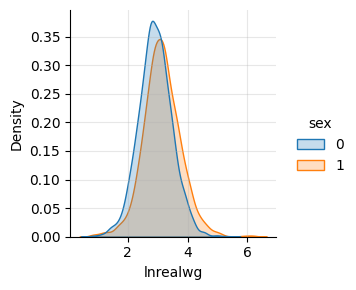

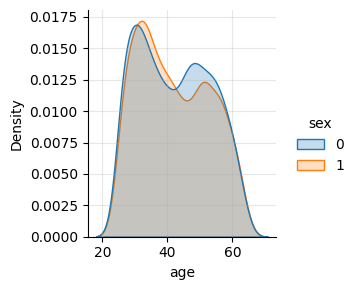

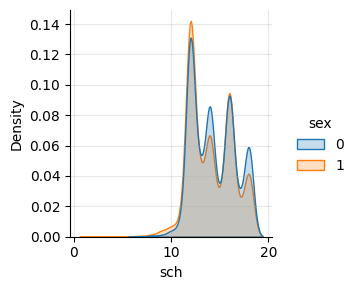

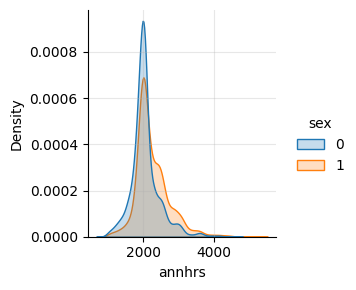

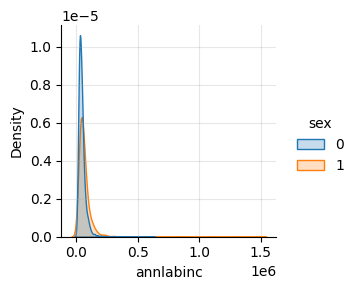

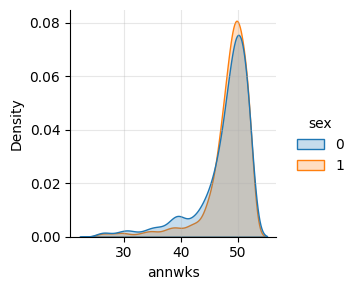

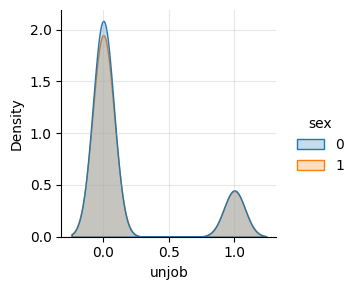

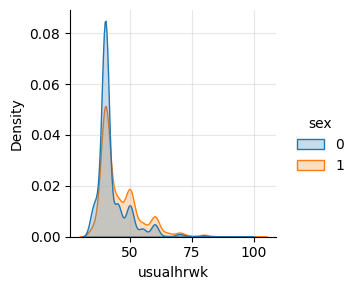

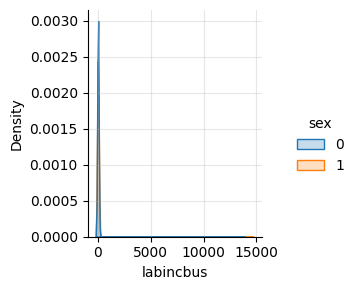

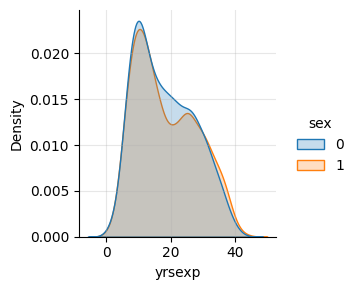

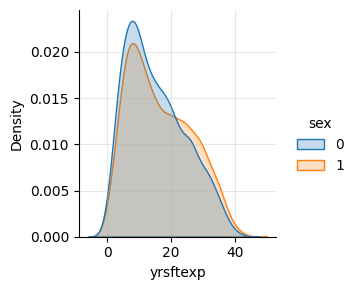

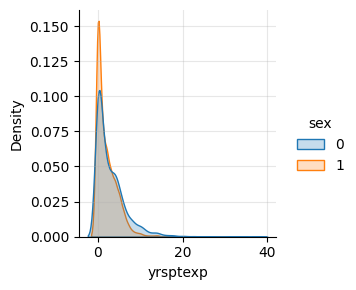

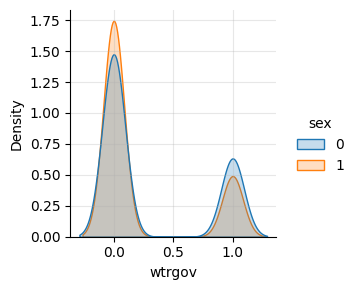

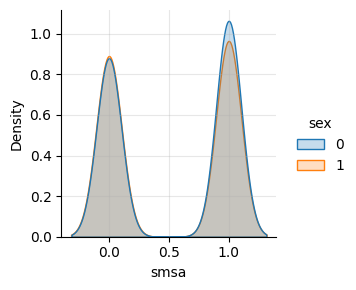

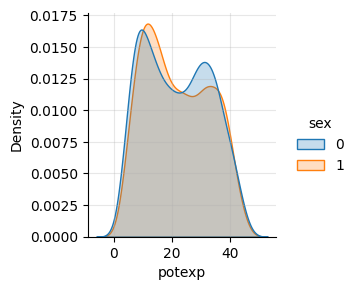

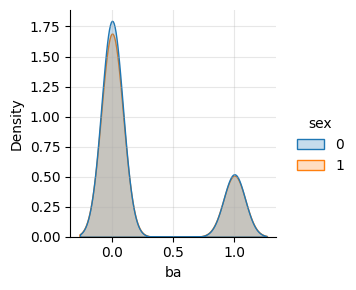

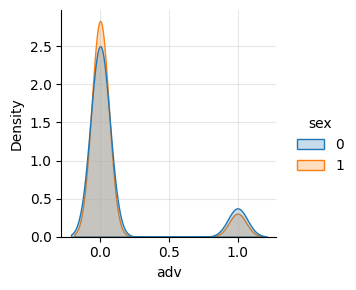

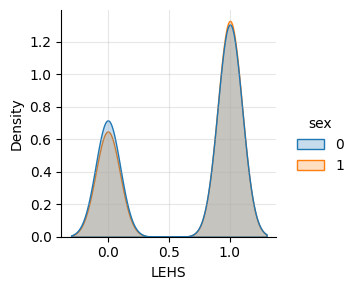

In [376]:
target = ['lnrealwg','age','sch','annhrs','annlabinc','annwks','unjob','usualhrwk','labincbus','yrsexp','yrsftexp','yrsptexp','wtrgov','smsa','potexp','ba','adv','LEHS']
for i in target:
    ax1 = sns.displot(adj_df, x=i, hue="sex", kind="kde", fill=True, height=3)
    plt.grid(alpha = 0.3)


In [380]:
# g = sns.FacetGrid(adj_df, col='Degree')
# g.map(sns.scatterplot, 'sex', 'lnrealwg', alpha=0.5)
# # g.set(ylim=(750, -10));

In [378]:
# g = sns.FacetGrid(adj_df, col='Degree', hue='sex')
# p1 = g.map(sns.distplot, 'lnrealwg')

In [379]:
# sns.pairplot(adj_df[['lnrealwg','sex','yrsexp','yrsftexp','yrsptexp','smsa']], hue="sex")

In [658]:
from statsmodels.formula.api import ols ,wls
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.diagnostic as smd

Text(0.5, 1.0, 'Box-Cox Transformations for y (real wage per hour)')

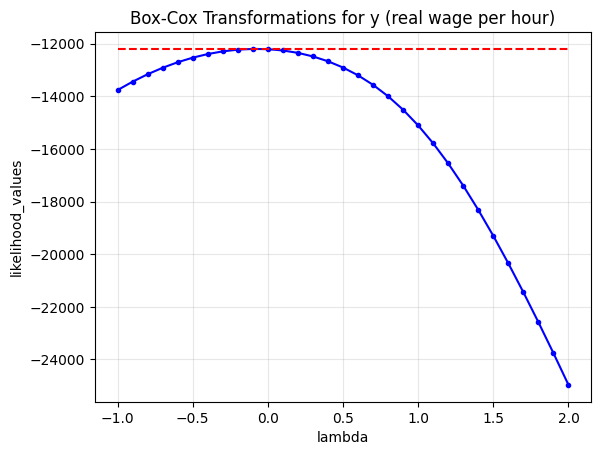

In [411]:
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df['realhrwage'])
lamb = np.linspace(-1, 2, 31)

likelihood_values = [stats.boxcox_llf(i, df['realhrwage']) for i in lamb]
plt.plot(lamb, likelihood_values, 'b.-')
plt.hlines(max(likelihood_values), -1, 2, colors='red', linestyles='--')
plt.grid(alpha = 0.3)
plt.xlabel('lambda')
plt.ylabel('likelihood_values')
plt.title('Box-Cox Transformations for y (real wage per hour)')
# plt.vlines(lamb[likelihood_values.index(max(likelihood_values))], -28000, max(likelihood_values))
# plt.ylim(-26000, -10000)

In [490]:
var_pool = ['lnrealwg', 'sex', 'age', 'sch', 'annhrs', 'white', 'black', 'hisp', 'othrace', 'annwks', 'unjob',
       'usualhrwk', 'labincbus', 'yrsexp', 'yrsftexp', 'yrsptexp', 'wtrgov', 'smsa',
       'northeast', 'northcentral', 'south', 'west', 'potexp', 'ba', 'adv', 'LEHS']

In [780]:
reg_data = adj_df[var_pool]
reg_data = pd.concat([reg_data, pd.get_dummies(adj_df['Industry'])*1, pd.get_dummies(adj_df['Degree'])*1, pd.get_dummies(adj_df['Relhead'])*1], axis=1)
reg_data.columns = [i.replace(" Occupations","").replace(" ","_").replace(",","").replace("’","") for i in reg_data.columns]
reg_data = reg_data.dropna()
reg_data = reg_data.reset_index(drop=True)

In [781]:
reg_result = []
reg_resid = {}
reg_fitval = {}
for i in reg_data.columns[1:]:
    reg_model = ols('lnrealwg ~ '+i, data=reg_data).fit()

    # beta
    beta = reg_model.params.iloc[1]
    # t-value
    tValue = reg_model.tvalues.iloc[1]
    # Durbin-Watson test statiitcs
    dwt = sms.durbin_watson(reg_model.resid)
    # Jarque-Bera test Chi^2 two-tail prob
    jbt = sms.jarque_bera(reg_model.resid)[1]
    # Breusch-Pagan Test p-value
    bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]
    reg_result.append([beta, abs(tValue), dwt, jbt, bpt])
    reg_fitval[i] = reg_model.fittedvalues
    reg_resid[i] = reg_model.resid

In [782]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [783]:
simple_reg_result = pd.DataFrame(reg_result, index=reg_data.columns[1:], columns=['beta','abs(tValue)','Durbin-Watson test','Jarque-Bera test (pValue)','Breusch-Pagan (pValue)']).sort_values('abs(tValue)', ascending=False)
simple_reg_result

,beta,abs(tValue),Durbin-Watson test,Jarque-Bera test (pValue),Breusch-Pagan (pValue)
sch,0.12,32.65,1.89,0.00,0.00
LEHS,-0.52,30.64,1.93,0.00,0.00
no_college_degree,-0.52,30.58,1.93,0.00,0.00
adv,0.55,20.91,1.92,0.00,0.07
advanced_degree,0.55,20.91,1.92,0.00,0.07
Management,0.55,19.06,1.94,0.00,0.09
black,-0.33,18.31,1.96,0.00,0.00
white,0.31,17.66,1.96,0.00,0.00
bachelors_without_advanced_degree,0.35,17.01,1.94,0.00,0.68
ba,0.35,17.01,1.94,0.00,0.68


C:\Users\Wei\AppData\Local\Temp\ipykernel_33252\898087964.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(8,3))


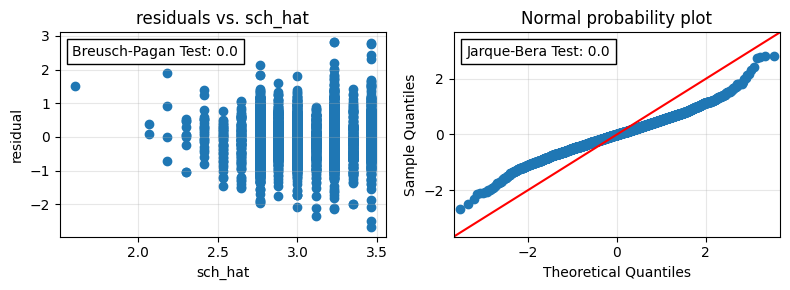

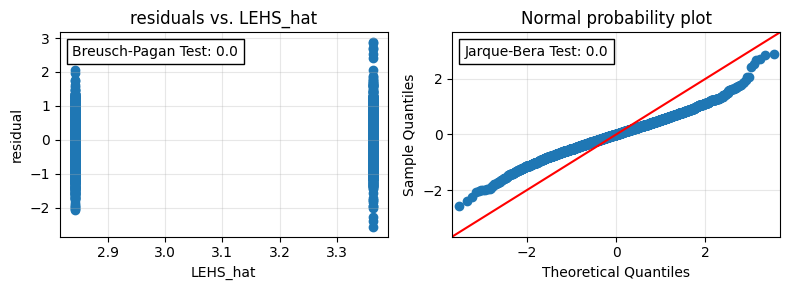

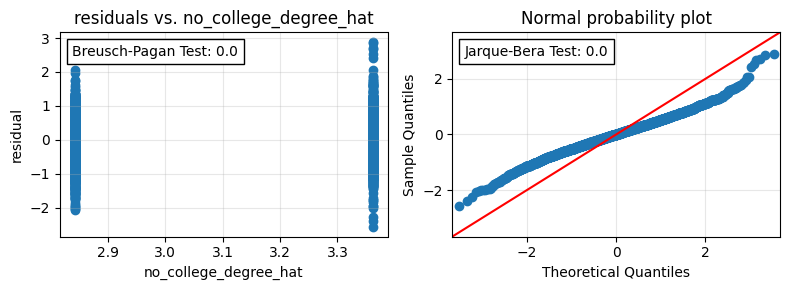

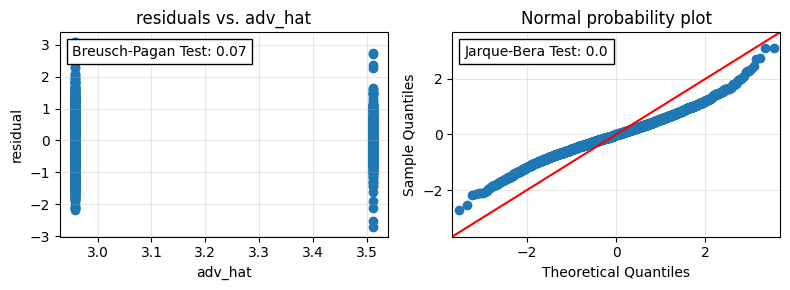

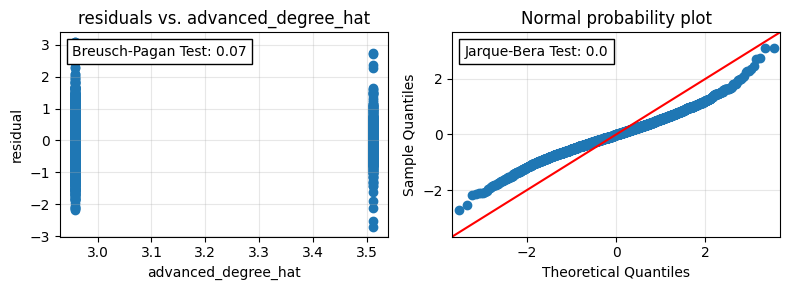

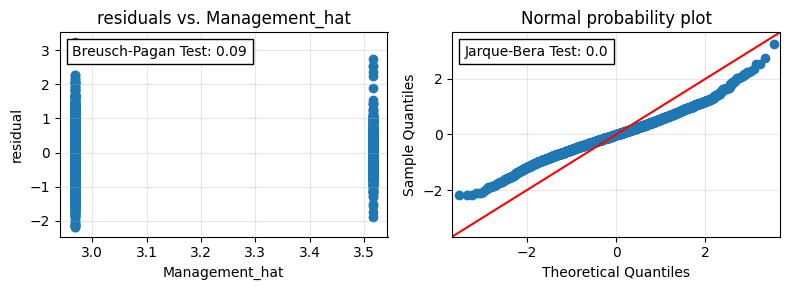

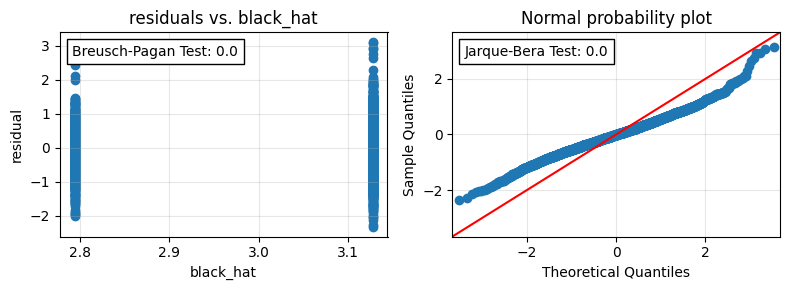

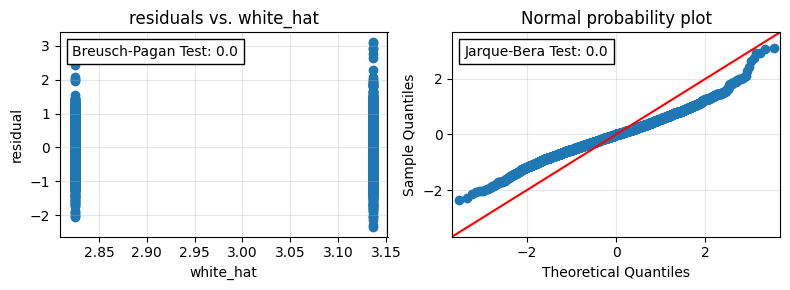

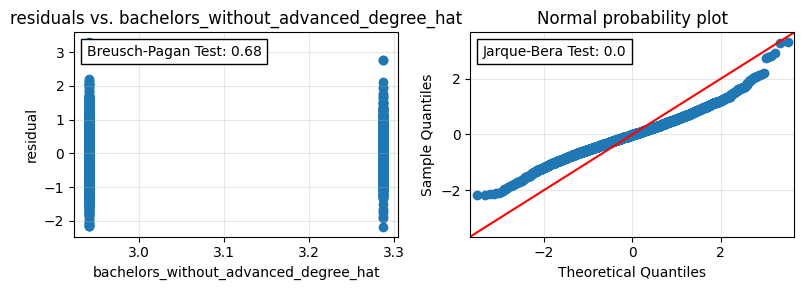

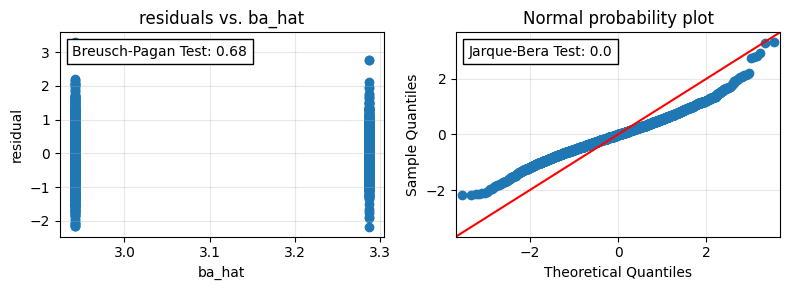

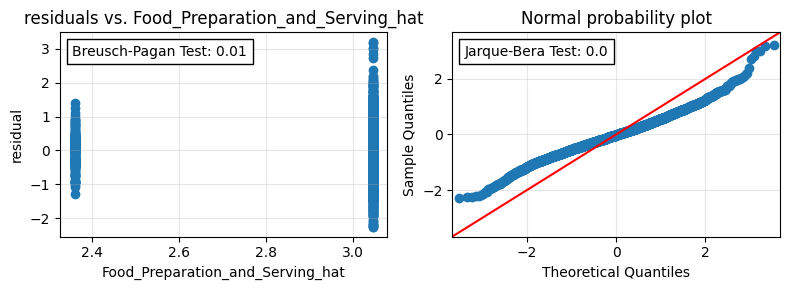

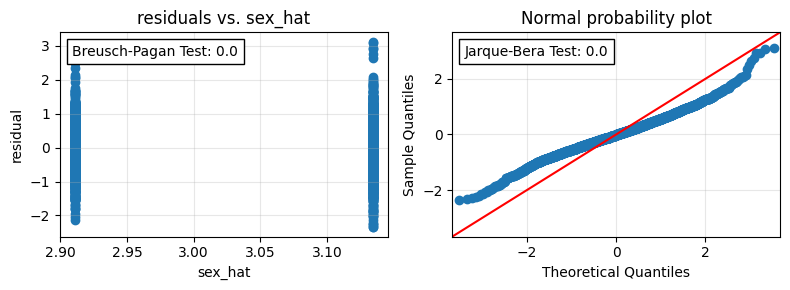

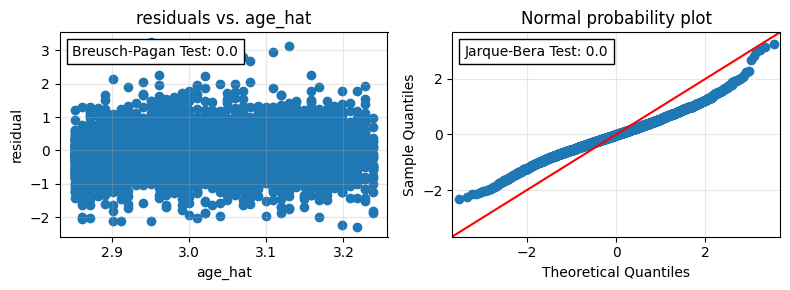

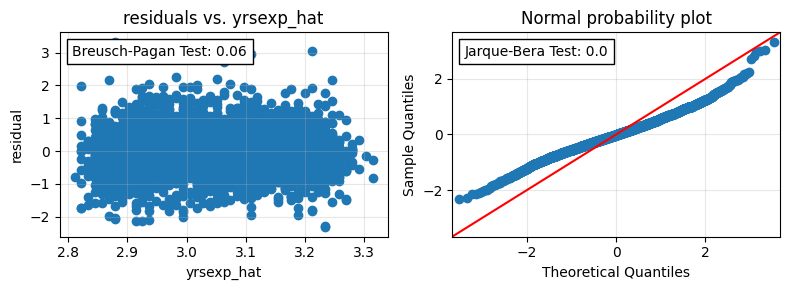

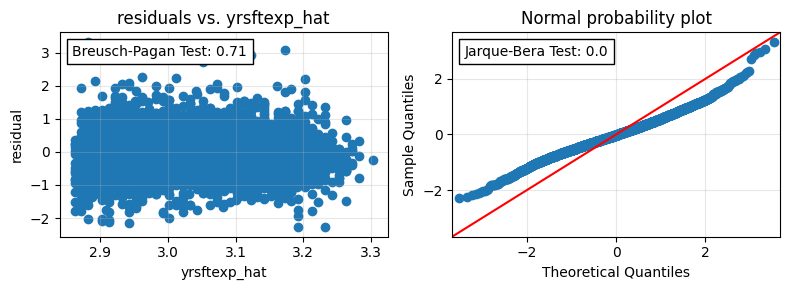

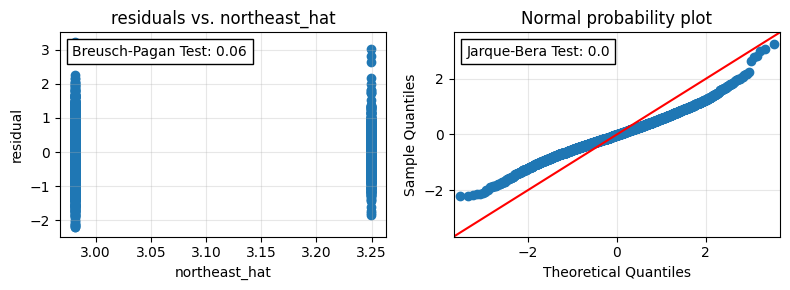

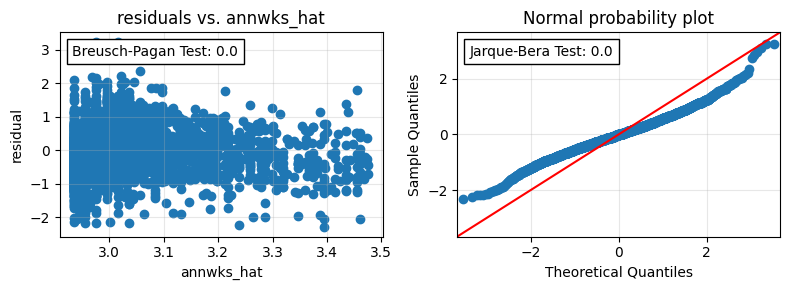

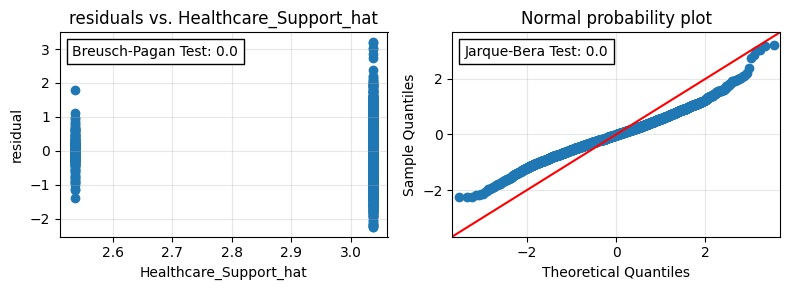

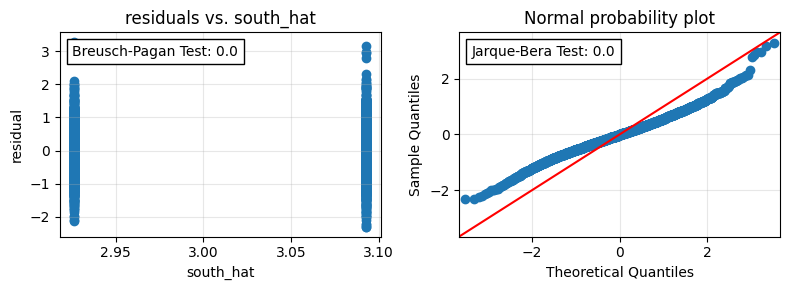

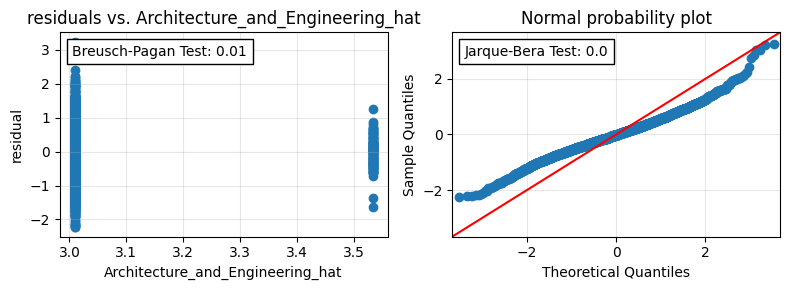

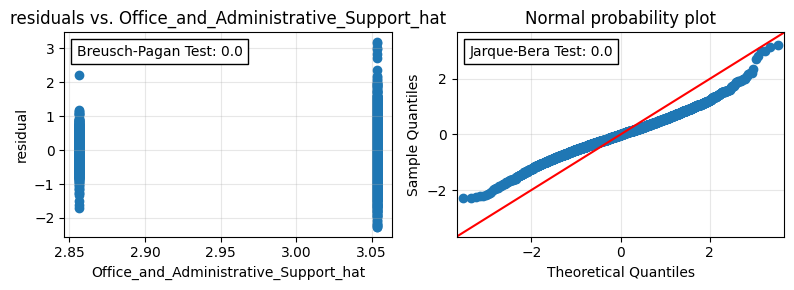

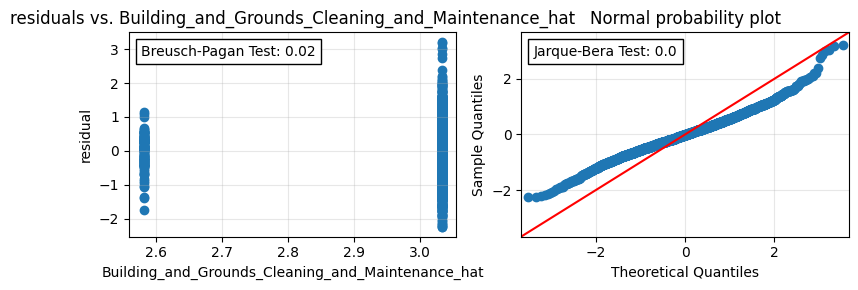

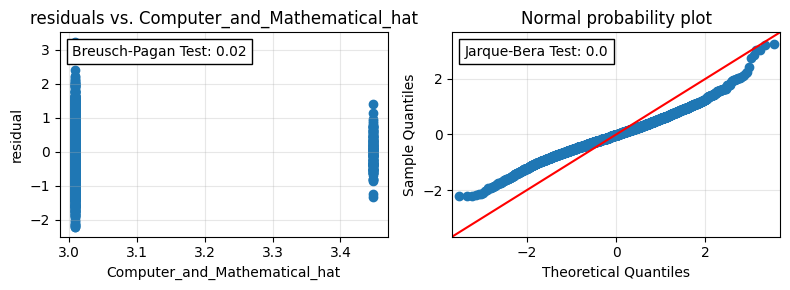

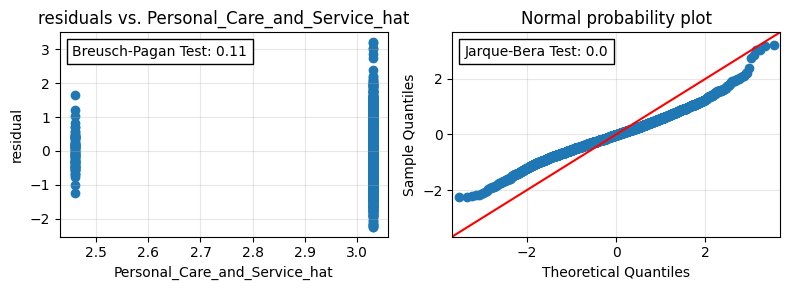

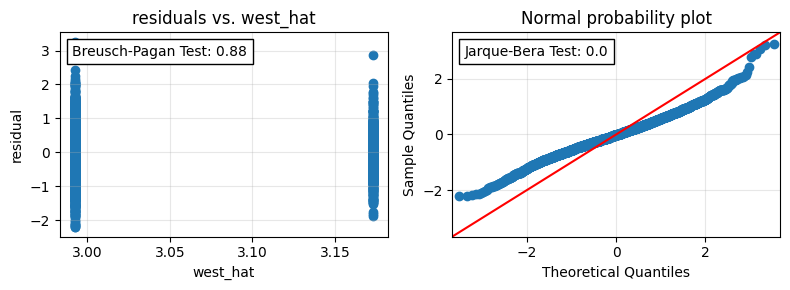

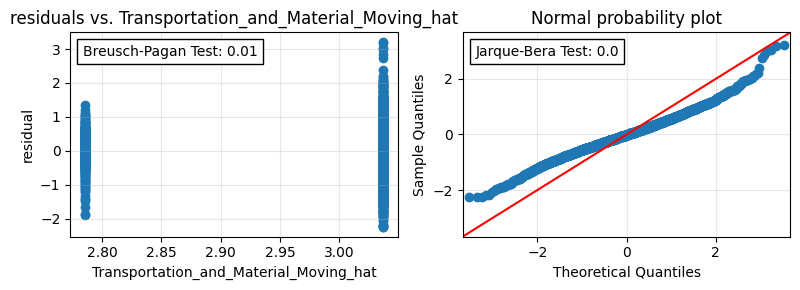

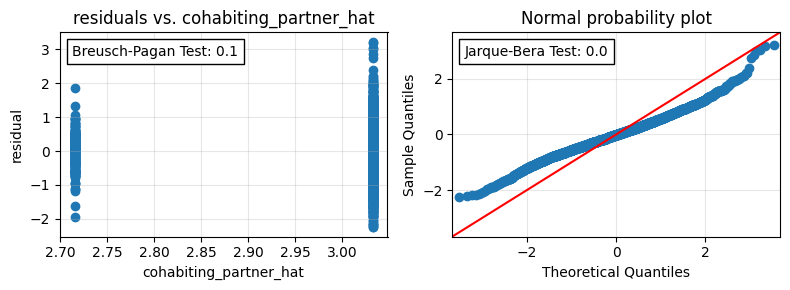

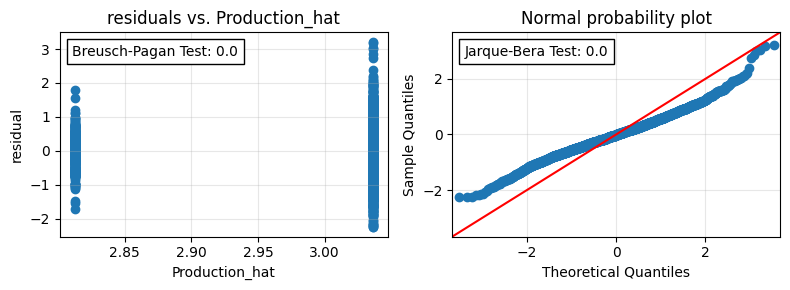

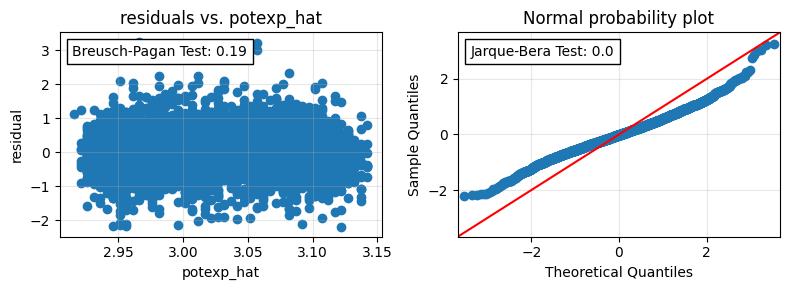

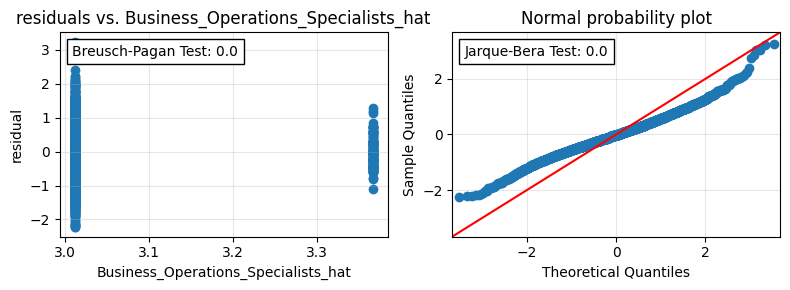

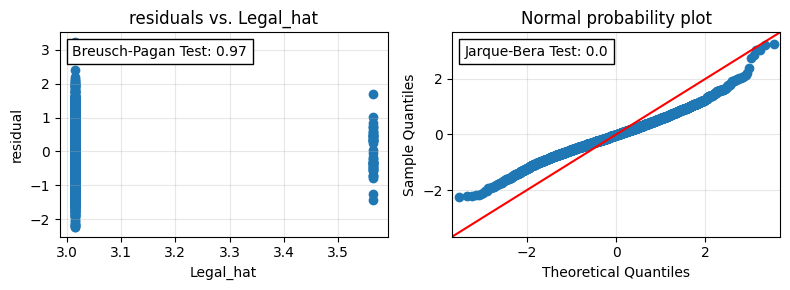

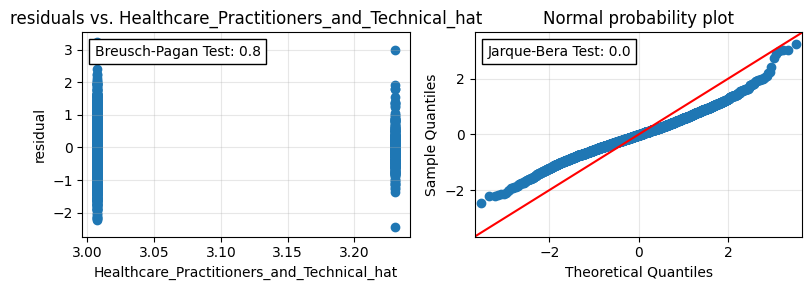

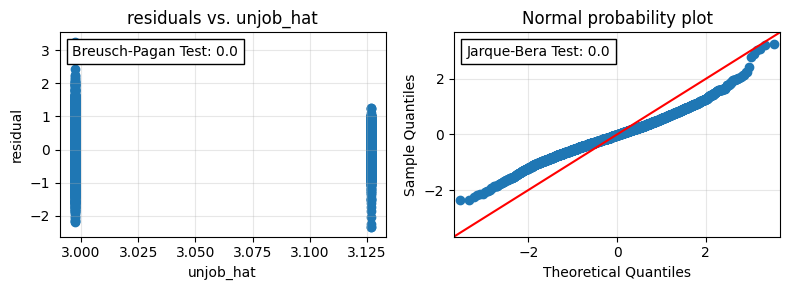

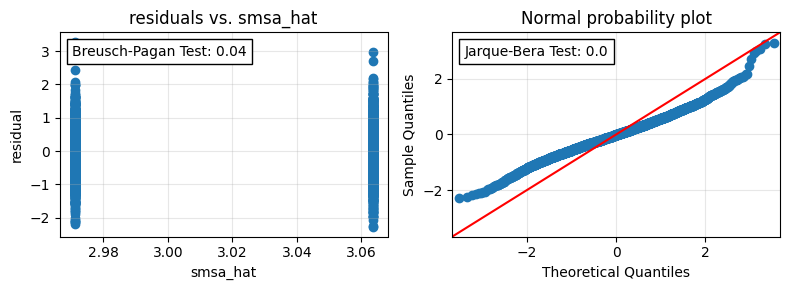

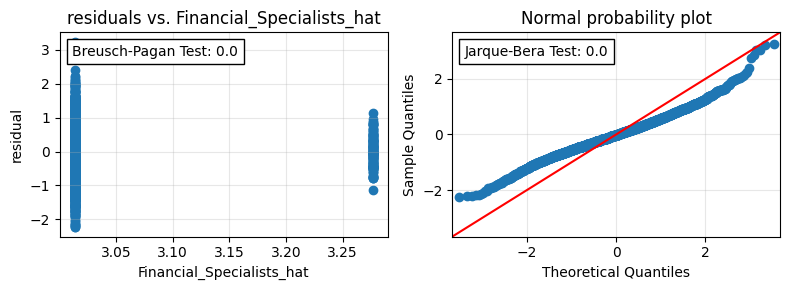

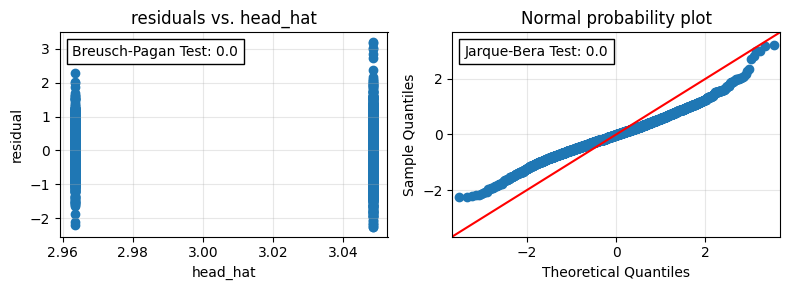

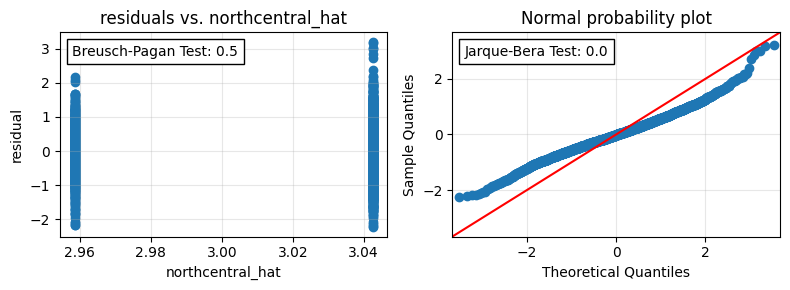

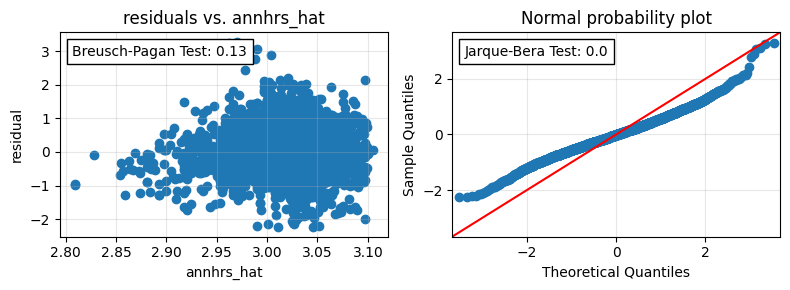

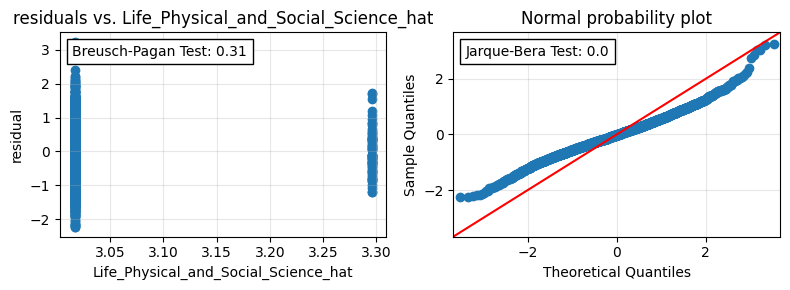

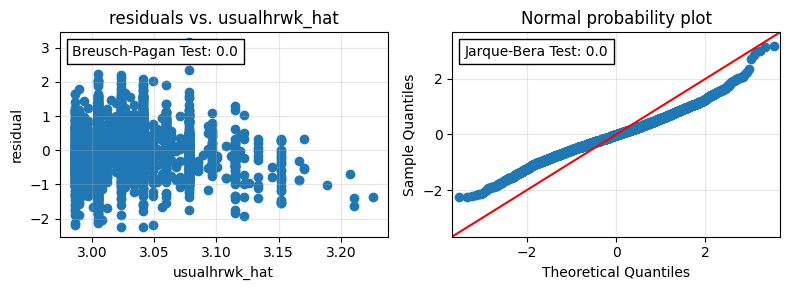

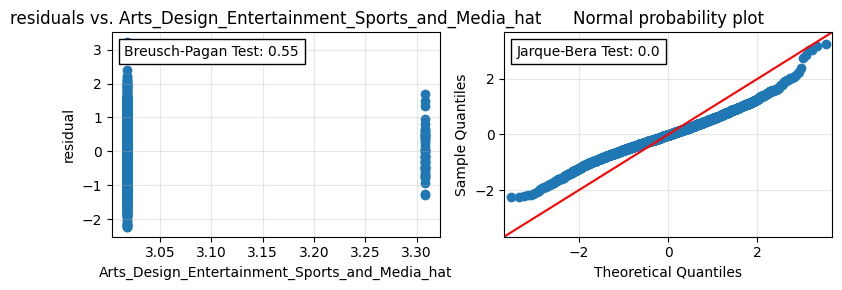

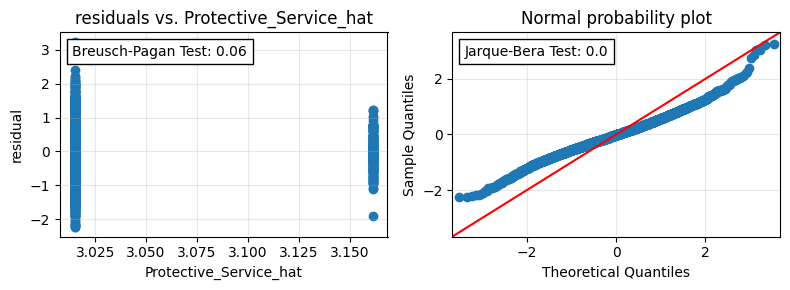

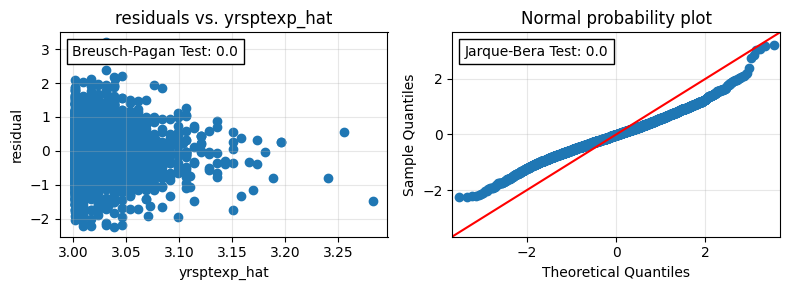

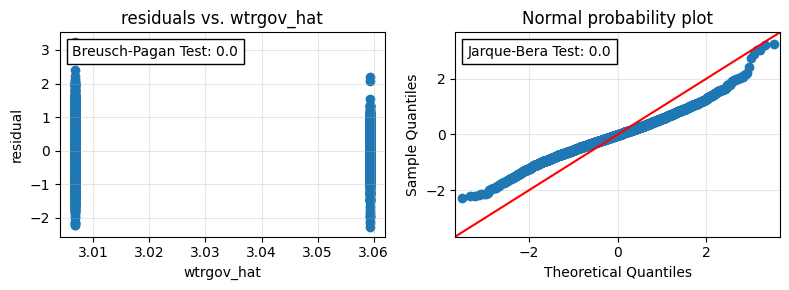

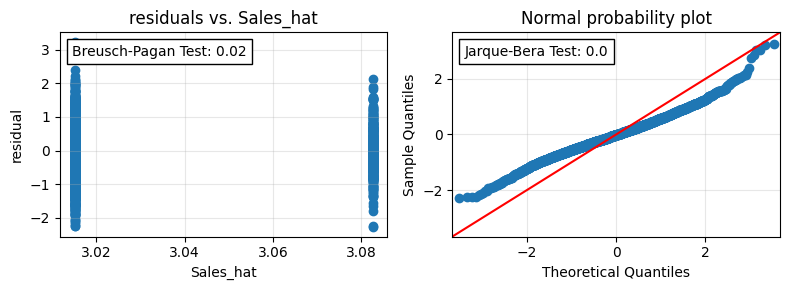

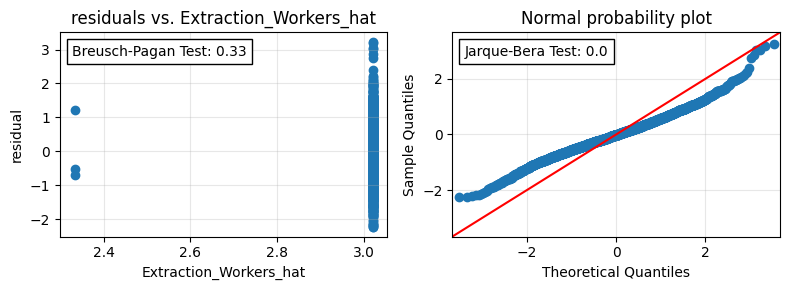

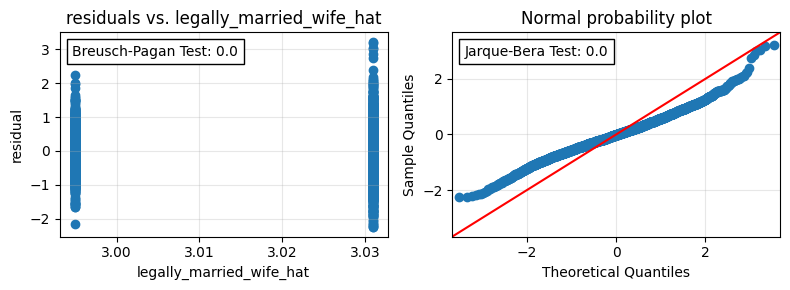

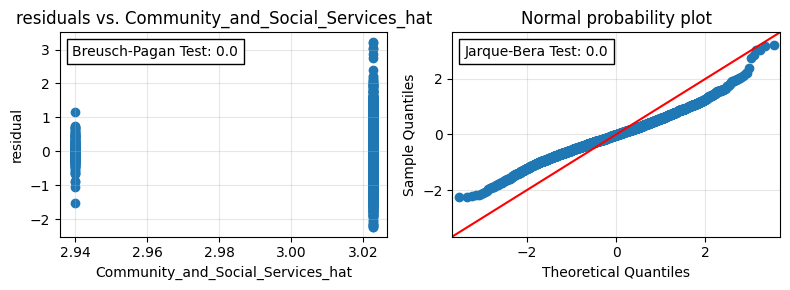

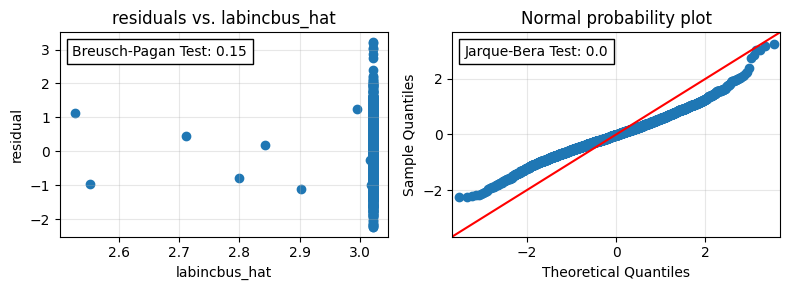

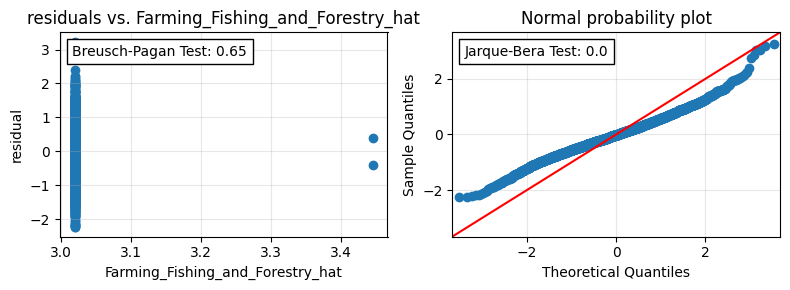

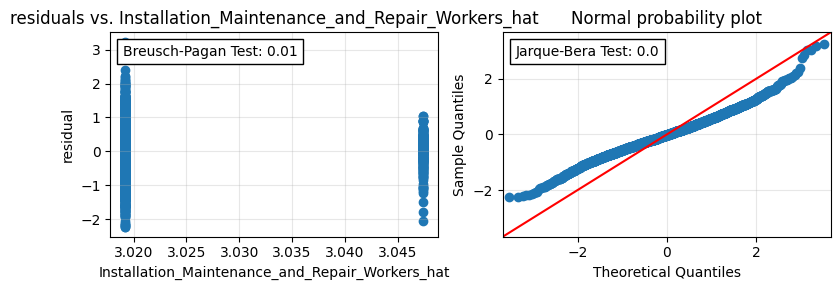

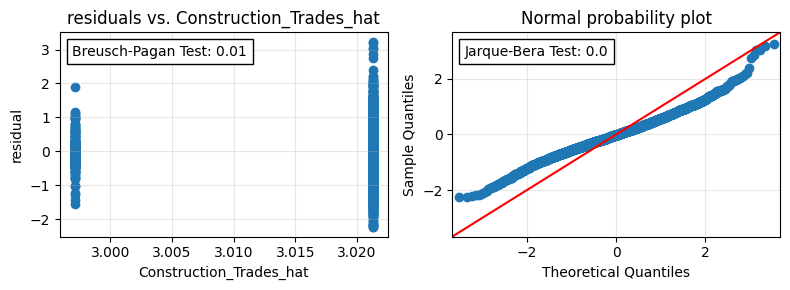

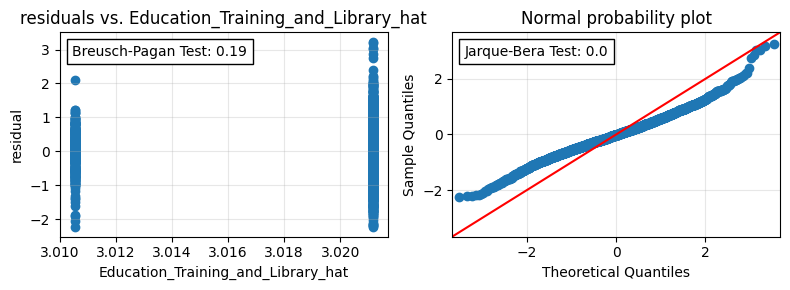

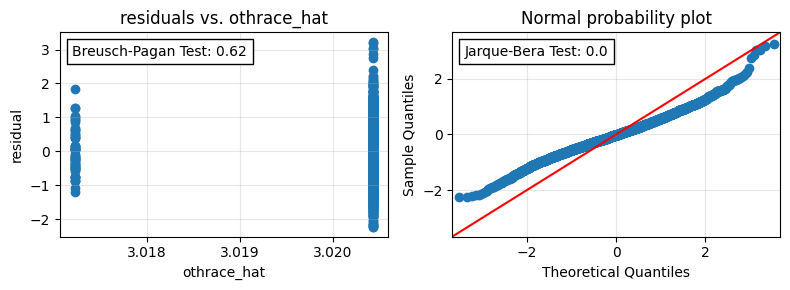

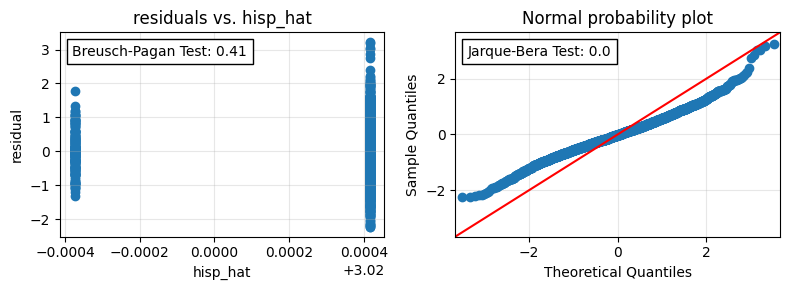

In [784]:
from matplotlib.offsetbox import AnchoredText
for i in simple_reg_result.index:
        fig, axs = plt.subplots(1, 2, figsize=(8,3))

        axs[0].scatter(reg_fitval[i], reg_resid[i])
        axs[0].grid(alpha = 0.3)
        axs[0].set_title('residuals vs. '+i+'_hat')
        axs[0].set_ylabel('residual')
        axs[0].set_xlabel(i+'_hat')
        anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(simple_reg_result.loc[i,'Breusch-Pagan (pValue)'],2)), loc=2)
        axs[0].add_artist(anchored_text)


        sm.qqplot(reg_resid[i], line="45", ax=axs[1])
        axs[1].grid(alpha = 0.3)
        axs[1].set_title('Normal probability plot')
        anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(simple_reg_result.loc[i,'Jarque-Bera test (pValue)'],2)), loc=2)
        axs[1].add_artist(anchored_text)
        fig.tight_layout()

In [785]:
# name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
# test = sms.jarque_bera(reg_model.resid)
# lzip(name, test)
# name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
# test = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)
# lzip(name, test)

In [786]:
candidate = simple_reg_result[simple_reg_result['abs(tValue)']>2]

In [787]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [871]:
muliple_variable = candidate.index[0] + " + "
muliple_variable_list = [candidate.index[0]]
for i in candidate.index.drop('sex')[1:]:
    muliple_variable += i
    muliple_variable_list.append(i)
    reg_model = ols('lnrealwg ~ '+muliple_variable, data=reg_data).fit()
    muliple_variable += ' + '
    
    VIF = pd.DataFrame()
    VIF['feature']  = muliple_variable_list
    VIF['VIF'] = [variance_inflation_factor(reg_data[muliple_variable_list].values, i) for i in range(reg_data[muliple_variable_list].shape[1])]
    if VIF['VIF'].max()> 1.5:
        muliple_variable = muliple_variable[:-len(i)-3]
        muliple_variable_list.remove(i)
        
muliple_variable = muliple_variable+'sex'
muliple_variable_list = muliple_variable_list+['sex']
reg_model = ols('lnrealwg ~ '+muliple_variable, data=reg_data).fit()
        
    

c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [931]:
VIF

,feature,VIF
0,sch,1.67
1,adv,1.27
2,Management,1.16
3,Food_Preparation_and_Serving,1.04
4,Healthcare_Support,1.04
5,Architecture_and_Engineering,1.03
6,Personal_Care_and_Service,1.02
7,Legal,1.04
8,Sales,1.12


In [855]:
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:               lnrealwg   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     223.8
Date:                Sun, 22 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:06:48   Log-Likelihood:                -3586.6
No. Observations:                4797   AIC:                             7193.
Df Residuals:                    4787   BIC:                             7258.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [856]:
# Durbin-Watson test statiitcs
dwt = sms.durbin_watson(reg_model.resid)
# Jarque-Bera test Chi^2 two-tail prob
jbt = sms.jarque_bera(reg_model.resid)[1]
# Breusch-Pagan Test p-value
bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]

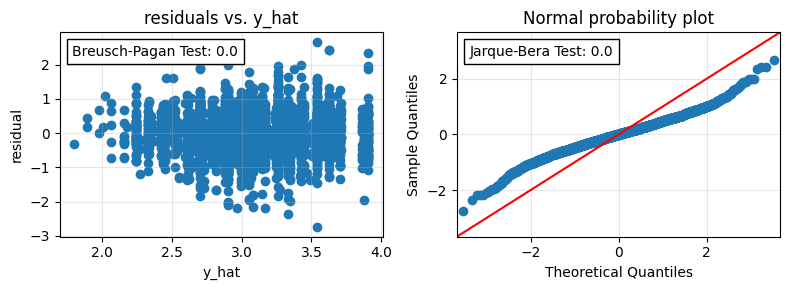

In [857]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].scatter(reg_model.fittedvalues, reg_model.resid)
axs[0].grid(alpha = 0.3)
axs[0].set_title('residuals vs. y_hat')
axs[0].set_ylabel('residual')
axs[0].set_xlabel('y_hat')
anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(bpt,2)), loc=2)
axs[0].add_artist(anchored_text)


sm.qqplot(reg_model.resid, line="45", ax=axs[1])
axs[1].grid(alpha = 0.3)
axs[1].set_title('Normal probability plot')
anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(jbt,2)), loc=2)
axs[1].add_artist(anchored_text)
fig.tight_layout()

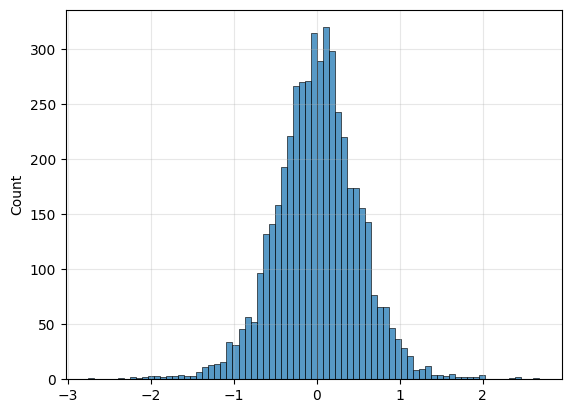

In [858]:
sns.histplot(reg_model.resid)
plt.grid(alpha=0.3)

<Axes: >

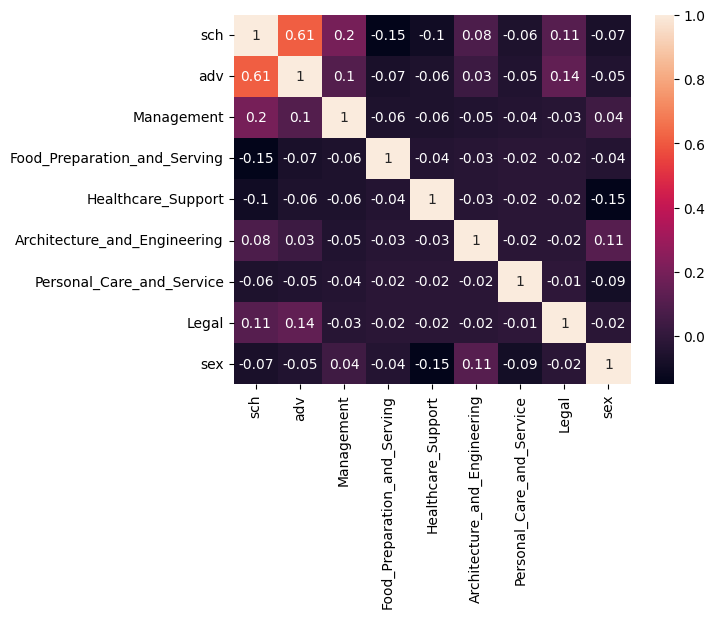

In [860]:
sns.heatmap(round(reg_data[muliple_variable_list].corr(),2), annot=True)

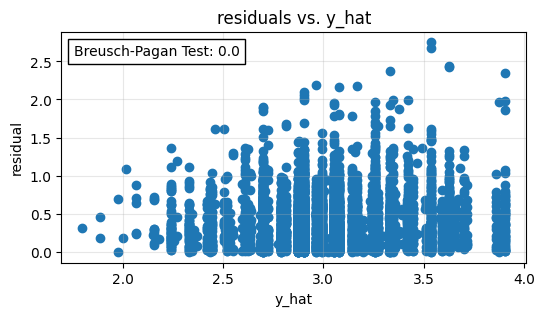

In [861]:
fig, axs = plt.subplots(1, 1, figsize=(6,3))

axs.scatter(reg_model.fittedvalues, abs(reg_model.resid))
axs.grid(alpha = 0.3)
axs.set_title('residuals vs. y_hat')
axs.set_ylabel('residual')
axs.set_xlabel('y_hat')
anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(bpt,2)), loc=2)
axs.add_artist(anchored_text)

In [862]:
residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
residual_data.columns = ['abs_residual', 'y_hat']
residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

In [864]:
wls_whole_model = wls('lnrealwg ~ '+muliple_variable, data=reg_data, weights = 1/residual_model.fittedvalues).fit()
print(wls_whole_model.summary())

                            WLS Regression Results                            
Dep. Variable:               lnrealwg   R-squared:                       0.296
Model:                            WLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     223.8
Date:                Sun, 22 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:07:16   Log-Likelihood:                -3563.9
No. Observations:                4797   AIC:                             7148.
Df Residuals:                    4787   BIC:                             7213.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [970]:
def press_criterion(reg_data, ind_variables, freq):
    press = 0
    for i in range(0, len(reg_data)-freq+1, freq):
        wls_model = wls('lnrealwg ~ '+ind_variables, data=reg_data.drop(range(i,i+freq)), weights = 1/residual_model.fittedvalues.drop(range(i,i+freq))).fit()
        press += ((wls_model.predict(reg_data[muliple_variable.split(' + ')].iloc[i:i+freq]).values[0] - reg_data['lnrealwg'][i:i+freq])**2).sum()
    return press

def mallows_cp(reg_data, muliple_variable_list, wls_whole_model, wls_model):
    c = wls_model.ssr/wls_whole_model.mse_resid-(len(reg_data)-2*(len(muliple_variable_list)+1)+1)
    return c
    
def combs(a):
    if len(a) == 0:
        return [[]]
    cs = []
    for c in combs(a[1:]):
        cs += [c, c+[a[0]]]
    return cs

In [971]:
powerset_var = combs(muliple_variable_list)[1:]
criterions = []
k = 0
for i in powerset_var:
    ind_var = str(i).replace("'",'').replace("[",'').replace("]",'').replace(",",' +')
    reg_model = ols('lnrealwg ~ '+ind_var, data=reg_data).fit()
    
    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()
    
    wls_model = wls('lnrealwg ~ '+ind_var, data=reg_data, weights = 1/residual_model.fittedvalues).fit()
    
    p = len(i)
    sse = wls_model.ssr
    rsq = wls_model.rsquared
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(reg_data, i, wls_whole_model, wls_model)
    aic = wls_model.aic
    bic = wls_model.bic
    press = press_criterion(reg_data, ind_var, 100)
    criterions.append([ind_var, p,sse,rsq,rsq_a,cp,aic,bic,press])
    k+=1
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [972]:
criterions_df = pd.DataFrame(criterions, columns=['ind_variables','p','SSE','R2','adj_R2','Cp','AIC','BIC','PRESS']).set_index('ind_variables')

In [979]:
criterions_df.sort_values('Cp').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS
ind_variables,,,,,,,,
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,8,3196.33,0.29,0.29,8.51,7158.58,7216.86,2120.62
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,9,3195.32,0.30,0.29,9.00,7147.80,7212.56,2105.97
sex + Legal + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,7,3201.97,0.29,0.29,14.97,7190.64,7242.45,2104.75
sex + Legal + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3201.61,0.29,0.29,16.43,7181.40,7239.69,2092.40
sex + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3201.68,0.29,0.29,16.53,7164.60,7222.88,2110.47
sex + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,7,3203.65,0.29,0.29,17.47,7178.43,7230.24,2126.67
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Food_Preparation_and_Serving + Management + adv + sch,8,3205.66,0.29,0.29,22.49,7188.33,7246.61,2104.85
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Food_Preparation_and_Serving + Management + sch,7,3207.11,0.29,0.29,22.66,7199.13,7250.93,2120.04
sex + Legal + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3205.92,0.29,0.29,22.88,7186.93,7245.21,2116.02


In [980]:
criterions_df.sort_values('PRESS').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS
ind_variables,,,,,,,,
sex + Legal,2,3711.85,0.04,0.04,768.82,8638.01,8657.43,1687.43
sex,1,3731.20,0.03,0.03,795.82,8678.88,8691.83,1687.48
sex + Legal + Personal_Care_and_Service,3,3693.94,0.05,0.05,744.00,8587.76,8613.66,1687.64
sex + Personal_Care_and_Service,2,3713.32,0.05,0.05,771.03,8627.89,8647.32,1688.17
sex + Legal + Healthcare_Support,3,3691.55,0.06,0.06,740.41,8560.13,8586.04,1703.31
sex + Architecture_and_Engineering,2,3730.70,0.04,0.04,797.07,8643.38,8662.80,1704.05
sex + Healthcare_Support,2,3710.41,0.05,0.05,766.67,8598.31,8617.74,1704.14
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering,4,3691.34,0.06,0.06,742.11,8548.96,8581.34,1704.25
sex + Personal_Care_and_Service + Architecture_and_Engineering,3,3712.51,0.05,0.05,771.82,8593.08,8618.98,1704.32


In [981]:
criterions_df.sort_values('adj_R2', ascending=False).head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS
ind_variables,,,,,,,,
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,9,3195.32,0.30,0.29,9.00,7147.80,7212.56,2105.97
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,8,3196.33,0.29,0.29,8.51,7158.58,7216.86,2120.62
sex + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3201.68,0.29,0.29,16.53,7164.60,7222.88,2110.47
sex + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,7,3203.65,0.29,0.29,17.47,7178.43,7230.24,2126.67
sex + Legal + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3201.61,0.29,0.29,16.43,7181.40,7239.69,2092.40
sex + Legal + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,7,3201.97,0.29,0.29,14.97,7190.64,7242.45,2104.75
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Food_Preparation_and_Serving + Management + adv + sch,8,3205.66,0.29,0.29,22.49,7188.33,7246.61,2104.85
sex + Legal + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3205.92,0.29,0.29,22.88,7186.93,7245.21,2116.02
sex + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,7,3207.57,0.29,0.29,23.35,7196.83,7248.64,2097.13


In [982]:
criterions_df.sort_values('AIC').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS
ind_variables,,,,,,,,
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,9,3195.32,0.30,0.29,9.00,7147.80,7212.56,2105.97
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,8,3196.33,0.29,0.29,8.51,7158.58,7216.86,2120.62
sex + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3201.68,0.29,0.29,16.53,7164.60,7222.88,2110.47
sex + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,7,3203.65,0.29,0.29,17.47,7178.43,7230.24,2126.67
sex + Legal + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3201.61,0.29,0.29,16.43,7181.40,7239.69,2092.40
sex + Legal + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3205.92,0.29,0.29,22.88,7186.93,7245.21,2116.02
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Food_Preparation_and_Serving + Management + adv + sch,8,3205.66,0.29,0.29,22.49,7188.33,7246.61,2104.85
sex + Legal + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,7,3201.97,0.29,0.29,14.97,7190.64,7242.45,2104.75
sex + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,7,3207.57,0.29,0.29,23.35,7196.83,7248.64,2097.13


In [983]:
criterions_df.sort_values('BIC').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS
ind_variables,,,,,,,,
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,9,3195.32,0.30,0.29,9.00,7147.80,7212.56,2105.97
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,8,3196.33,0.29,0.29,8.51,7158.58,7216.86,2120.62
sex + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3201.68,0.29,0.29,16.53,7164.60,7222.88,2110.47
sex + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,7,3203.65,0.29,0.29,17.47,7178.43,7230.24,2126.67
sex + Legal + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3201.61,0.29,0.29,16.43,7181.40,7239.69,2092.40
sex + Legal + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,7,3201.97,0.29,0.29,14.97,7190.64,7242.45,2104.75
sex + Legal + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3205.92,0.29,0.29,22.88,7186.93,7245.21,2116.02
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Food_Preparation_and_Serving + Management + adv + sch,8,3205.66,0.29,0.29,22.49,7188.33,7246.61,2104.85
sex + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,7,3207.57,0.29,0.29,23.35,7196.83,7248.64,2097.13


In [984]:
criterions_df.sort_values('SSE').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS
ind_variables,,,,,,,,
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,9,3195.32,0.30,0.29,9.00,7147.80,7212.56,2105.97
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,8,3196.33,0.29,0.29,8.51,7158.58,7216.86,2120.62
sex + Legal + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3201.61,0.29,0.29,16.43,7181.40,7239.69,2092.40
sex + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3201.68,0.29,0.29,16.53,7164.60,7222.88,2110.47
sex + Legal + Personal_Care_and_Service + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,7,3201.97,0.29,0.29,14.97,7190.64,7242.45,2104.75
sex + Personal_Care_and_Service + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + sch,7,3203.65,0.29,0.29,17.47,7178.43,7230.24,2126.67
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Food_Preparation_and_Serving + Management + adv + sch,8,3205.66,0.29,0.29,22.49,7188.33,7246.61,2104.85
sex + Legal + Architecture_and_Engineering + Healthcare_Support + Food_Preparation_and_Serving + Management + adv + sch,8,3205.92,0.29,0.29,22.88,7186.93,7245.21,2116.02
sex + Legal + Personal_Care_and_Service + Architecture_and_Engineering + Food_Preparation_and_Serving + Management + sch,7,3207.11,0.29,0.29,22.66,7199.13,7250.93,2120.04


In [733]:
sm.stats.anova_lm(wls_model, typ=3) 

,sum_sq,df,F,PR(>F)
Intercept,497.11,1.00,744.73,0.00
sch,281.53,1.00,421.77,0.00
adv,8.02,1.00,12.01,0.00
Management,125.27,1.00,187.67,0.00
Food_Preparation_and_Serving,100.39,1.00,150.40,0.00
Healthcare_Support,28.97,1.00,43.41,0.00
Architecture_and_Engineering,26.35,1.00,39.48,0.00
Personal_Care_and_Service,29.55,1.00,44.27,0.00
Legal,11.81,1.00,17.70,0.00
sex,115.15,1.00,172.50,0.00
